In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from PIL import Image
import skimage
from skimage import measure
from skimage import color
import cv2
%matplotlib inline

Using TensorFlow backend.


In [2]:
#path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
path = r"C:\\Users\\naren\\Documents\\LER\\"

#model = load_model(path + 'models/' + 'EDGEnet_run_epoch_4.h5')

model = load_model(path + 'LER_machine_learning\\models\\' + 'LineNet_image4_round_L2_rotation_epoch_5.h5')
#model.summary()

C:\Users\naren\Anaconda3\envs\old_tf\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [3]:
def iso_LER(predict, start_pos=15, length=120, dist=15, offset = 100, xlength = 120, \
            denoise_min_peak=0.4, edge_min_peak=0.15):

    #--------------- Function to measure isolated line LER ----------------
    nedges = 2
    predicted_edges_denoiseIm = np.zeros((nedges, length))
    predicted_edges_edgeIm = np.zeros((nedges, length))

    for i in range(start_pos, start_pos + length):
        peaks, _ = find_peaks(predict[i,offset:(offset+xlength),0], height = denoise_min_peak, distance = dist)
        predicted_edges_denoiseIm[:,i - start_pos] = offset + peaks[:nedges]
        
    for i in range(start_pos, start_pos + length):
        peaks, _ = find_peaks(predict[i,offset:(offset+xlength),1], height = edge_min_peak, distance = dist)
        predicted_edges_edgeIm[:,i - start_pos] = offset + peaks[:nedges]
    
    if FOV ==2:
        pixel_size = (2000/482)
    
    denoiseIm_LER = (3*pixel_size*predicted_edges_denoiseIm.std(axis = 1)*np.sqrt(length/(length-2)))
    edgeIm_LER = (3*pixel_size*predicted_edges_edgeIm.std(axis = 1)*np.sqrt(length/(length-2)))
    
    return denoiseIm_LER, edgeIm_LER, predicted_edges_denoiseIm, predicted_edges_edgeIm

In [4]:
def dense_LER(predict, start_pos=121, length=120, offset = 100, xlength = 96, \
              dist=15, denoise_min_peak=0.35, edge_min_peak=0.11):

    #--------------- Function to measure dense line LER ----------------
    nedges = 2
    predicted_edges_denoiseIm = np.zeros((nedges, length))
    predicted_edges_edgeIm = np.zeros((nedges, length))

    for i in range(start_pos, start_pos + length):
        peaks, _ = find_peaks(predict[i,offset:(offset+xlength),0], height = denoise_min_peak, distance = dist)
        predicted_edges_denoiseIm[:,i - start_pos] = offset + peaks[:nedges]
        
    for i in range(start_pos, start_pos + length):
        peaks, _ = find_peaks(predict[i,offset:(offset+xlength),1], height = edge_min_peak, distance = dist)
        predicted_edges_edgeIm[:,i - start_pos] = offset + peaks[:nedges]
    
    if FOV ==2:
        pixel_size = (2000/482)
    
    denoiseIm_LER = (3*pixel_size*predicted_edges_denoiseIm.std(axis = 1)*np.sqrt(length/(length-2)))
    edgeIm_LER = (3*pixel_size*predicted_edges_edgeIm.std(axis = 1)*np.sqrt(length/(length-2)))
    
    return denoiseIm_LER, edgeIm_LER, predicted_edges_denoiseIm, predicted_edges_edgeIm

(480, 480)
0.0 0.99609375
(480, 480, 2)


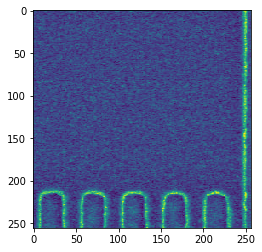

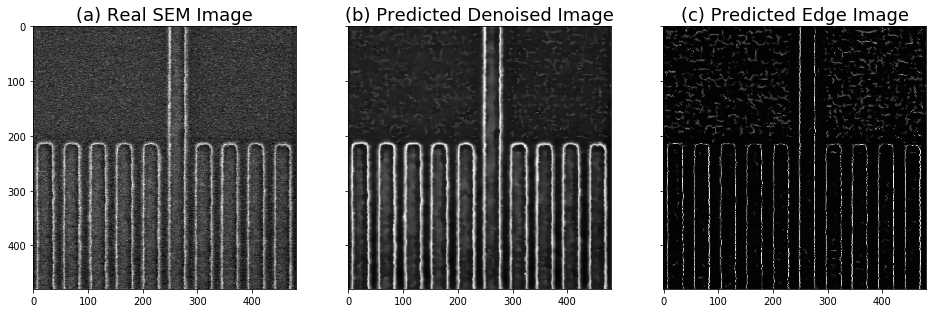

In [5]:
#noisy_file = r'C:\Users\narendra\Documents\LER\For_Texas_AM_University\2_CDSEM_for_TAMU_Sep2019\100NM_P2_V (2).jpg'
noisy_file = r'C:\Users\naren\Documents\LER\For_Texas_AM_University\data4' + \
            '\FhG_IPMS_CDSEM_LER_Jan2020\E2OU920400_18_E0142_002_LER_LITHO_1\PatternFOV' + \
            '\E0142_002_LER_E0142_002_LER_UP_FX2_FY0_RR1_TR1_Ver1.jpg'

imnoisy = np.array(Image.open(noisy_file))

if 'RIGHT' in noisy_file:
    imnoisy = np.rot90(imnoisy)

FOV = 2

imnoisy = imnoisy / 256
print(imnoisy.shape)
plt.imshow(imnoisy)
print(imnoisy.min(), imnoisy.max())
plt.imshow(imnoisy[0:256, 0:256])
    
if FOV == 2:
    #imnoisy = imnoisy[:444,:]
    #imnoisy = np.pad(imnoisy, ((0, 36), (0, 0)), 'constant') 
    
    imnoisy = imnoisy.reshape(1,480,480,1)
    predict = np.zeros([1,480,480,2])
    patch = np.zeros([4,256,256,2])
    patch[0,:,:] = model.predict(imnoisy[:,0:256,0:256,:])
    patch[1,:,:] = model.predict(imnoisy[:,224:,0:256,:])
    patch[2,:,:] = model.predict(imnoisy[:,0:256,224:,:])
    patch[3,:,:] = model.predict(imnoisy[:,224:,224:,:])
    
    mid_x = 230
    mid_y = 230
    predict[:,0:mid_x, 0:mid_y,:] = patch[0,0:mid_x, 0:mid_y,:]
    predict[:,mid_x:, 0:mid_y,:] = patch[1,(mid_x - 224):, 0:mid_y,:]
    predict[:,0:mid_x, mid_y:,:] = patch[2,0:mid_x, (mid_y - 224):,:]
    predict[:,mid_x:, mid_y:,:] = patch[3,(mid_x - 224):, (mid_y - 224):,:]
    predict = predict.reshape(480,480,2)
    imnoisy = imnoisy.reshape(480,480)

print(predict.shape)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 16), sharex=True,
                       sharey=True)


ax[0].imshow(imnoisy, cmap = 'gray')
ax[0].set_title('(a) Real SEM Image', fontsize=18)
ax[1].imshow(predict[:,:,0], cmap = 'gray')
ax[1].set_title('(b) Predicted Denoised Image', fontsize=18)
ax[2].imshow(predict[:,:,1], cmap = 'gray')
ax[2].set_title('(c) Predicted Edge Image', fontsize=18)
plt.show()


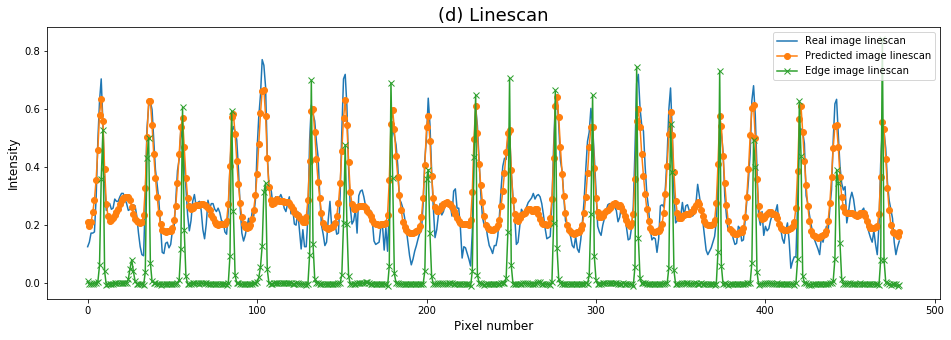

In [6]:
number = 350
plt.figure(figsize = (16,5))
plt.plot(imnoisy[number,:], label = 'Real image linescan')
#plt.plot(imsimulated[number,:], label = 'simulated data')
plt.plot(predict[number,:,0], '-o',label = 'Predicted image linescan')
plt.plot(predict[number,:,1], '-x',label = 'Edge image linescan')
plt.xlabel('Pixel number', fontsize=12)
plt.ylabel('Intensity', fontsize=12)
plt.title('(d) Linescan', fontsize=18)
plt.legend()
plt.show()

(480, 480)


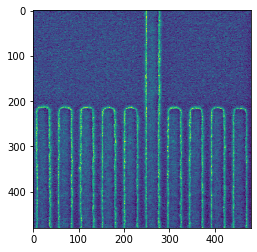

In [7]:
noisy_file = r'C:\Users\naren\Documents\LER\For_Texas_AM_University\data4' + \
            '\FhG_IPMS_CDSEM_LER_Jan2020\E2OU920400_18_E0142_002_LER_LITHO_1\PatternFOV' + \
            '\E0142_002_LER_E0142_002_LER_UP_FX2_FY0_RR1_TR1_Ver1.jpg'

imnoisy = np.array(Image.open(noisy_file))

FOV = 2

if 'RIGHT' in noisy_file:
    imnoisy = np.rot90(imnoisy)

imnoisy = imnoisy / 256
print(imnoisy.shape)
plt.imshow(imnoisy)

[5.11 5.29] [7.58 6.74]
Mean LER:  5.1997781766661895 7.1615712603263955


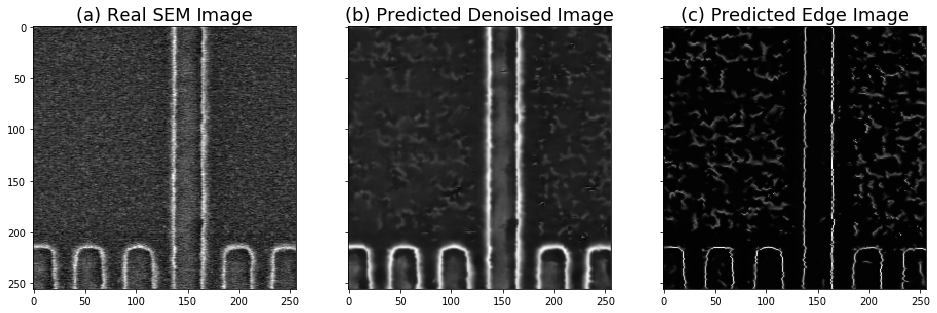

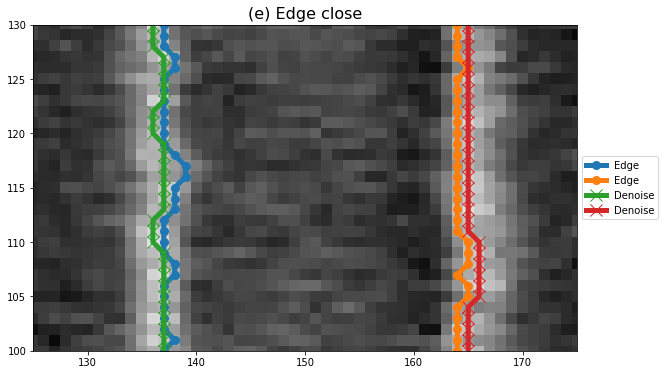

In [27]:
"""
Central measurement for isolated line
"""

from scipy.signal import find_peaks    # To get maxima

off = 130

imnoisy = imnoisy.reshape(1,480,480,1)
im_iso = imnoisy[:,0:256,240-128:240+128,:]


predict_iso = model.predict(im_iso)
predict_iso = predict_iso.reshape(256,256,2)
    
start_pos = 15
length = 120
denoiseIm_LER, edgeIm_LER, predicted_edges_denoiseIm, predicted_edges_edgeIm = iso_LER(predict_iso, \
                                                                                       start_pos=start_pos, length=length,\
                                                                                       offset = off)

print(np.around(denoiseIm_LER, 2), np.around(edgeIm_LER, 2))
print("Mean LER: ", denoiseIm_LER.mean(), edgeIm_LER.mean())

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 16), sharex=True,
                       sharey=True)
ax[0].imshow(im_iso[0,:,:,0], cmap='gray')
ax[0].set_title('(a) Real SEM Image', fontsize=18)
ax[1].imshow(predict_iso[:,:,0], cmap = 'gray')
ax[1].set_title('(b) Predicted Denoised Image', fontsize=18)
ax[2].imshow(predict_iso[:,:,1], cmap='gray')
ax[2].set_title('(c) Predicted Edge Image', fontsize=18)
plt.show()


plt.figure(figsize = (12,6))
plt.imshow(im_iso[0,:,:,0], cmap = 'gray')
plt.plot(predicted_edges_denoiseIm[:].T, range(start_pos, start_pos + length), '-x', label = 'Denoise', linewidth=5, markersize=12)
plt.plot(predicted_edges_edgeIm[:].T, range(start_pos, start_pos + length), '-o', label = 'Edge', linewidth=5, markersize=8)
plt.ylim(100,130)
plt.xlim(125,175)
plt.title('(e) Edge close', fontsize = 16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Mean LER:  5.1997781766661895 7.1615712603263955


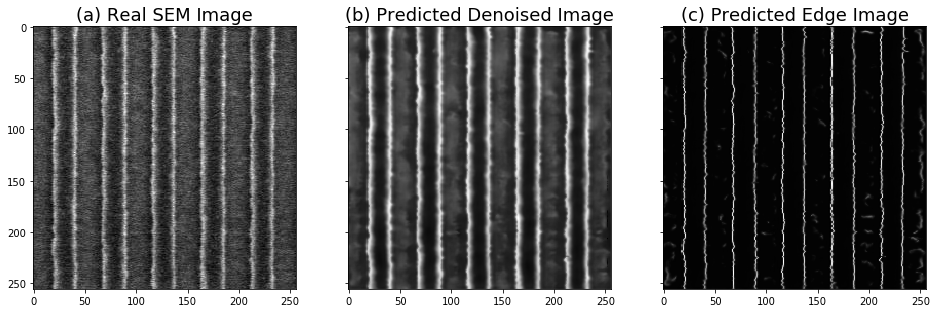

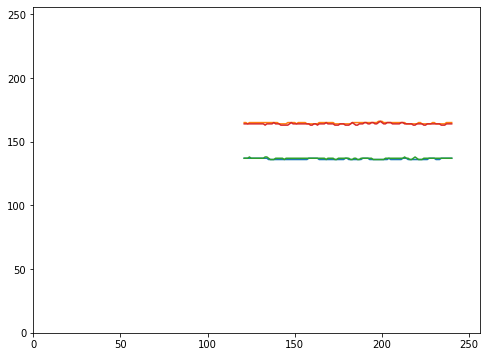

In [9]:
imnoisy = imnoisy.reshape(1,480,480,1)
im_dense = imnoisy[:,224:,240-128:240+128,:]

predict_dense = model.predict(im_dense)
predict_dense = predict_dense.reshape(256,256,2)
predict_dense = predict_dense.reshape(256,256,2)


start_pos = 121
length = 120
dense_denoiseIm_LER, dense_edgeIm_LER, predicted_edges_denoiseIm, predicted_edges_edgeIm = dense_LER(predict_dense, \
                                                                                       start_pos=start_pos, length=length,
                                                                                       offset = off)

print("Mean LER: ", denoiseIm_LER.mean(), edgeIm_LER.mean())

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 16), sharex=True,
                       sharey=True)
ax[0].imshow(im_dense[0,:,:,0], cmap='gray')
ax[0].set_title('(a) Real SEM Image', fontsize=18)
ax[1].imshow(predict_dense[:,:,0], cmap = 'gray')
ax[1].set_title('(b) Predicted Denoised Image', fontsize=18)
ax[2].imshow(predict_dense[:,:,1], cmap='gray')
ax[2].set_title('(c) Predicted Edge Image', fontsize=18)
plt.show()


plt.figure(figsize = (8,6))
plt.plot(range(start_pos, start_pos + length), predicted_edges_denoiseIm[:].T, label = 'denoise')
plt.plot(range(start_pos, start_pos + length), predicted_edges_edgeIm[:].T, label = 'edge')
plt.ylim(0,256)
plt.xlim(0,256)
plt.show()

In [10]:
print("isolated") 
print(np.around(denoiseIm_LER, 2), np.around(edgeIm_LER, 2)) 
print("dense") 
print(np.around(dense_denoiseIm_LER, 2), np.around(dense_edgeIm_LER, 2))

isolated
[5.11 5.29] [7.58 6.74]
dense
[5.95 6.55] [5.76 7.48]
